# BLINK

## **IMPORTS**
\
Dans cette partie nous importons les bibliothèques necessaires au projet, nous importons l'extrait sonore et nous introduisons quelque variables utiles pour la suite.

https://musicandcomputersbook.com

In [18]:
#Imports des bibliothèques
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt

In [19]:
# Charger le fichier audio
filename = 'fichiers_audio/voix_4_notes.wav'
sr, y = wavfile.read(filename)  # sr est le taux d'échantillonnage, y est le signal audio en tant que array

# Variables utiles pour la suite
taille_extrait = len(y)
y_min, y_max = np.min(y), np.max(y)  # valeurs min et max prises par les amplitudes du signal
freq = 1 / sr  # fréquence d'échantillonnage
T = [i * freq for i in range(len(y))]  # Liste des abscisses (temps) de chaque point de y

## **AFFICHAGE DE L'EXTRAIT EN TEMPOREL ET FRÉQUENTIEL**
\
Dans cette partie nous allons créer les fonctions necessaires à l'import de l'extrait audio, et les fonctions necessaires au passage temporel/fréquentiel grâce à la FFT (Fast Fourier Transform). Nous vérifierons que les fonctions sont complémentaires et fonctionnent ensemble, c'est à dire que IFFT(FFT(y)) = y et FFT(IFFT(Y)) = Y.

In [20]:
# Fonction pour calculer la transformée de Fourier d'un extrait
def TF_extrait(extrait, sr):
    Y = np.fft.fft(extrait)
    L_freqs = np.fft.fftfreq(len(Y), 1 / sr)
    return Y, L_freqs

# Fonction pour calculer la transformée de Fourier inverse d'un spectre
def ITF_extrait(spectre):
    extrait = np.fft.ifft(spectre)
    return extrait

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


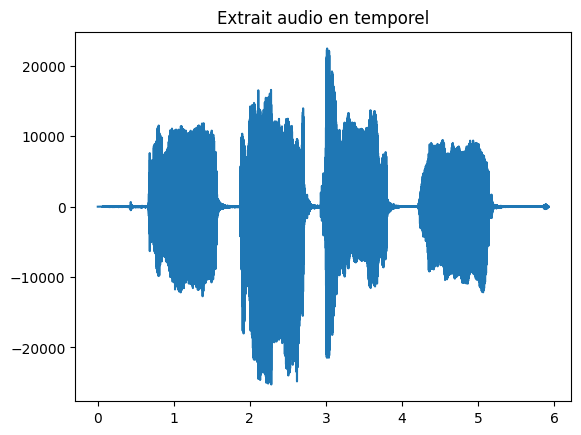

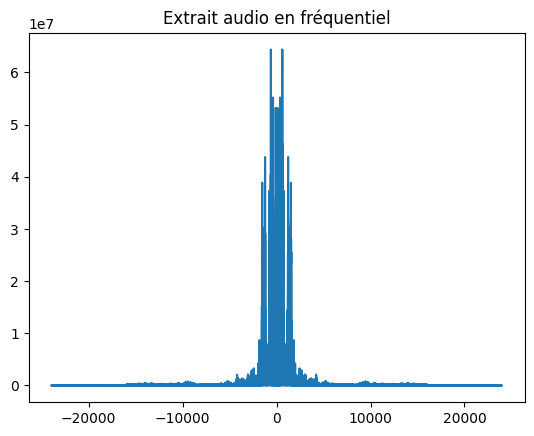

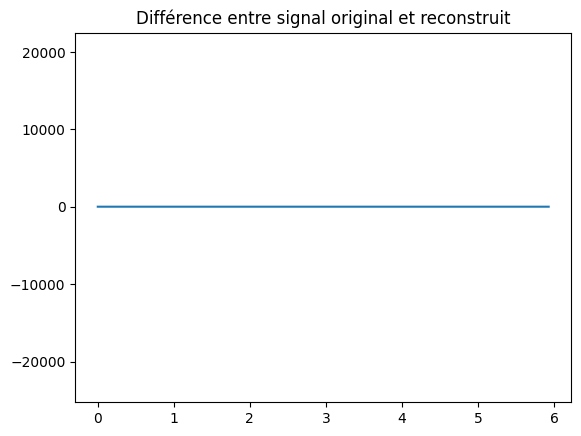

In [21]:
# Affichage du signal temporel
plt.figure(1)
plt.title("Extrait audio en temporel")
plt.plot(T, y)

Y, freqs = TF_extrait(y, sr)
plt.figure(2)
plt.title("Extrait audio en fréquentiel")
plt.plot(freqs, np.abs(Y))

y_reconstruit = ITF_extrait(Y)
diff = y_reconstruit - y
plt.figure(3)
plt.title("Différence entre signal original et reconstruit")
plt.plot(T, diff)
plt.ylim([y_min, y_max])

plt.show()

Les fonctions de calcul de FFT et IFFT fonctionnent correctement, et la dernière figure montre que les deux fonctions sont bien inverses l'unes de l'autres. En réalité la différence ne fait pas exactement 0, il y a une erreur de l'ordre de 10e-12 venant des approximations de calcul. Ces erreurs sont fortement négligeables devant l'amplitude de l'information dans le signal réel.

## **CRÉATION DU SONAGRAMME**
\
Le but est de créer un sonagramme : pour un extrait sonore complexe qui contient plus qu'une note, ça n'a pas de sens de regarder la répartition fréquetielle du signal total puisque le but est de trouver à chaque instant quelles sont les notes jouées. Nous allons alors découper le signal en segments suffisamment petits pour que le son y soit considéré stationnaire. Ensuit nous pourrons regarder la transformée de Fourier sur chaque semgent, pour savoir à chaque instant quelles sont les notes perçues.\
Nous pourrons ensuite regarder l'évolution temporelle de la répatition fréquentielle, c'est à dire tracer la répartition fréquentielle pour chaque segment du son considéré.

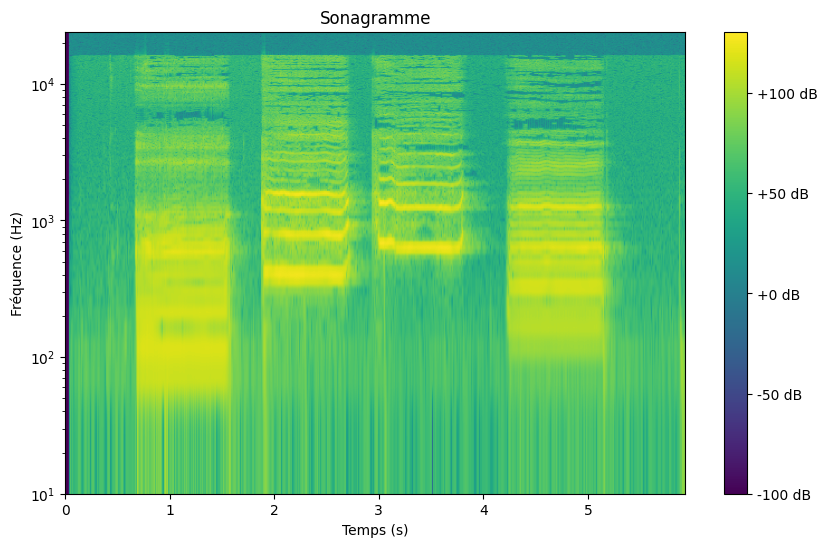

In [22]:
# Paramètres pour le découpage du signal
window_size = 1024  # Taille de chaque segment en nombre d'échantillons
hop_size = 512  # Décalage entre les segments en nombre d'échantillons

# Calculer le nombre de segments
num_segments = (len(y) - window_size) // hop_size + 1

# Initialiser une liste pour stocker la puissance spectrale
spectrogram = []

# Découper le signal en segments et calculer la FFT de chaque segment
for i in range(num_segments):
    start = i * hop_size
    end = start + window_size
    segment = y[start:end]
    
    # On applique une fenêtre de Hanning pour appliquer la finitude en temps
    window = np.hanning(window_size)
    segment = segment * window
    
    # Calculer la FFT du segment
    Y, freqs = TF_extrait(segment, sr)
    
    # Calcul de la puissance spectrale
    power_spectrum = np.abs(Y[:window_size // 2]) ** 2  # Utiliser seulement la moitié positive des fréquences
    
    # Ajouter au spectrogramme
    spectrogram.append(power_spectrum)

# Convertir la liste en tableau numpy
spectrogram_tableau = np.array(spectrogram).T  # Transposer pour avoir les temps en colonnes et les fréquences en lignes

# Tracer le sonagramme
plt.figure(figsize=(10,6))
plt.imshow(10 * np.log10(spectrogram_tableau + 1e-10), aspect='auto', origin='lower',
           extent=[0, len(y) / sr, 0, sr / 2])
plt.colorbar(format='%+2.0f dB')
plt.title('Sonagramme')
plt.xlabel('Temps (s)')
plt.ylabel('Fréquence (Hz)')
plt.yscale('log')
plt.ylim([10, sr/2])  # Ajuster l'axe y pour correspondre à l'échelle logarithmique


plt.show()

Le sonagramme a été mis en échelle log sur les fréquences, pour mieux voir les distinctions en basses fréquences (plus représentées pour un signal sonore).

In [23]:
# TODO :  VÉRIFIER QUE LE SONAGRAMME FONCTIONNE BIEN, AVEC DES SIGNAUX HARMONIQUES SIMPLES

## **EXTRACTION DU SON**
\
Dans cette partie nous allons extraire la fréquence fontamentale à chaque instant, dans le but d'obtenir la note pure émise par l'instrument et ensuite pouvoir lui appliquer les modulations voulues pour transformer l'instrument en synthétiseur.

ValueError: x and y must have same first dimension, but have shapes (284672,) and (555,)

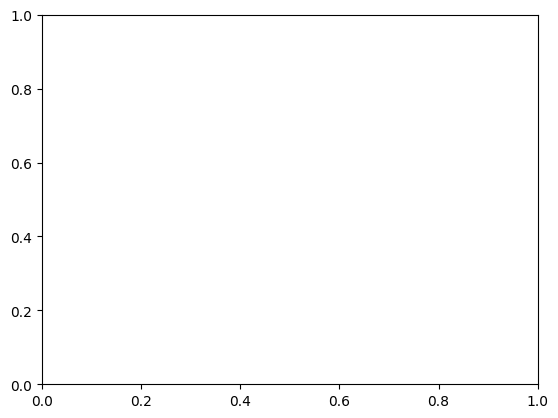

In [24]:
def extraction_fonda(spectro):
    L_freq_fonda = []
    nb_temps = len(spectro)
    for i in range(nb_temps):
        spectre = spectro[i] # spectre à l'instant i
        nb_freq = len(spectre)
        freq_fonda = 0
        for j in range(nb_freq):
            if spectre[j] > spectre[freq_fonda]:
                freq_fonda = j
        L_freq_fonda.append(freq_fonda) 
    return L_freq_fonda




## **SIMULATION DE PÉDALES D'EFFETS**
\
Dans cette partie nous allons essayer de reproduire les effets produits par des pédales, que ce soit des effets agissant sur le spectre ou sur le signal lui même.

In [ ]:
def Filtre(signal):
    return

In [ ]:
def Reverb(signal):
    return